In [17]:
import pandas as pd

In [18]:
# Read the CSV as a single column
df = pd.read_csv("scheduling_results_4_classes_cleaned_50x20_21-02-2025.csv", header=None)

# Split into multiple columns using the semicolon as a delimiter
df = df[0].str.split(';', expand=True)

In [19]:
# Assign proper column names
df.columns = ['instance', 'jobs', 'machines', 'strategy', 'tw', 'compression', 
              'overlapping', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap', 'makespan', 'gap_to_opt_percent', 'opt_class']

# Verify the DataFrame
print(df.head())

  instance jobs machines strategy tw compression overlapping  \
0     TA61   50       20    EST-M  2         Yes          No   
1     TA62   50       20    EST-M  2         Yes          No   
2     TA63   50       20    EST-M  2         Yes          No   
3     TA64   50       20    EST-M  2         Yes          No   
4     TA65   50       20    EST-M  2         Yes          No   

  #op_tw_with_overlap #op_tw #op_only_overlap makespan gap_to_opt_percent  \
0                 500    500                0     3376                 18   
1                 500    500                0     3490                 22   
2                 500    500                0     3271                 19   
3                 500    500                0     3225                 19   
4                 500    500                0     3200                 17   

  opt_class  
0         1  
1         2  
2         1  
3         1  
4         1  


In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import cross_val_score

In [21]:
# Convert numeric columns to appropriate types
numeric_cols = ['jobs', 'machines', 'tw', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap', 'makespan', 'gap_to_opt_percent']
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Encode categorical variables (e.g., 'strategy', 'compression', 'overlapping')
label_encoder = LabelEncoder()
categorical_cols = ['strategy', 'compression', 'overlapping']
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])


# Define the features (X) and the target variable (y)
x = df[['jobs', 'machines', 'strategy', 'tw', 'compression', 'overlapping', '#op_tw_with_overlap', '#op_tw', '#op_only_overlap']]
y = df['gap_to_opt_percent']  # Target variable for regression

In [22]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [23]:
# Train the Boosted Trees Regressor (Gradient Boosting)
boosted_regressor = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

# Perform 10-fold cross-validation on the entire dataset before fitting
cv_scores = cross_val_score(boosted_regressor, x, y, cv=10, scoring='r2')

# Print cross-validation results
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy from Cross-Validation:", cv_scores.mean())

boosted_regressor.fit(x_train, y_train)

# Predict on the test set
y_pred = boosted_regressor.predict(x_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = (abs((y_test - y_pred) / y_test).mean()) * 100

print("Mean Squared Error:", mse)
print("R2 Score:", r2)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")

Cross-Validation Scores: [ -1.82753381 -19.73127819  -7.53767614  -3.11266695   0.63524734
  -0.95575312  -0.47641759  -0.27476641  -0.15324578  -0.35505134]
Mean Accuracy from Cross-Validation: -3.3789141986073536
Mean Squared Error: 248.02649542085393
R2 Score: 0.41345634748825155
Mean Absolute Percentage Error (MAPE): 39.20458926318472 %


C:\Users\Mohammed El-Kholany\AppData\Local\Temp\ipykernel_28140\1994637471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')


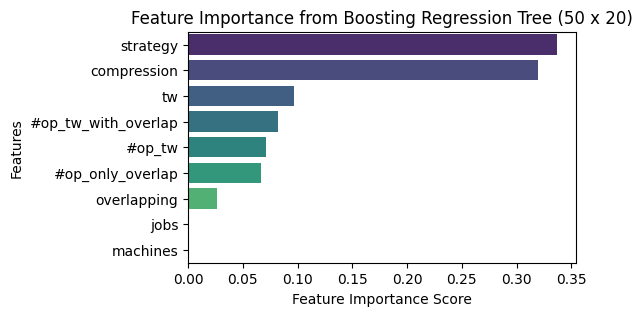

In [25]:
# Feature Importance Analysis
feature_importances = boosted_regressor.feature_importances_
features = x.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importances
plt.figure(figsize=(5, 3))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance from Boosting Regression Tree (50 x 20)")
plt.show()